# Machine learning for Credit Card Transactions

In [1]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In [2]:
import os
import sys

sys.path.append(f"{os.getcwd()}/..")

from utils import DATA_DIR

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

## Load Dataset and build graph

In [3]:
import kaggle

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
from kaggle.api_client import ApiClient

api = KaggleApi(ApiClient())
api.authenticate()

In [5]:
api.dataset_download_cli("kartik2112/fraud-detection")

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0
fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
from zipfile import ZipFile

In [7]:
myzip = ZipFile("fraud-detection.zip")

In [8]:
tmp_file = myzip.extract("fraudTrain.csv", path=DATA_DIR)

In [9]:
myzip.close()

In [10]:
import pandas as pd
df = pd.read_csv(os.path.join(DATA_DIR, "fraudTrain.csv"))
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [11]:
df["is_fraud"].value_counts()

0    257834
1      7506
Name: is_fraud, dtype: int64

In [12]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)

    name = graph_type.name
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)

    G.name = name
    
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

In [13]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    name = graph_type.name
    
    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    G.name = name

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

In [14]:
G_bu = build_graph_bipartite(df, nx.Graph(name="Bipartite Undirect"))
G_bd = build_graph_bipartite(df, nx.DiGraph(name="Bipartite Direct"))

G_tu = build_graph_tripartite(df, nx.Graph(name="Tripartite Undirect"))
G_td = build_graph_tripartite(df, nx.DiGraph(name="Tripartite Direct")) 

In [15]:
from networkx.algorithms import bipartite
all([bipartite.is_bipartite(G) for G in [G_bu,G_tu]])

True

## Network Analysis

In [16]:
for G in [G_bu, G_tu]:
    print(nx.info(G))

Name: Bipartite Undirect
Type: Graph
Number of nodes: 1676
Number of edges: 201725
Average degree: 240.7220
Name: Tripartite Undirect
Type: Graph
Number of nodes: 267016
Number of edges: 530680
Average degree:   3.9749


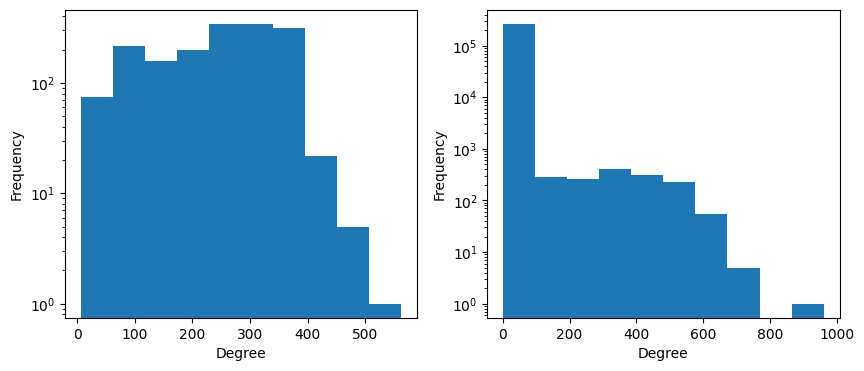

In [17]:
plt.figure(figsize=(10,4))
for ith, G in enumerate([G_bu, G_tu]):
    plt.subplot(1,2,ith+1)
    degrees = pd.Series({k: v for k, v in nx.degree(G)})
    degrees.plot.hist()
    plt.yscale("log")
    plt.xlabel("Degree")

In [18]:
quant_dist = {}

for ith, G in enumerate([G_bu, G_tu]):
    allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})

    quant_dist[G.name] = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0]) 
    print(quant_dist[G.name])

[5.03 58.25 98.44 215.66 15305.95]
[4.21 48.51 76.40 147.10 15305.95]


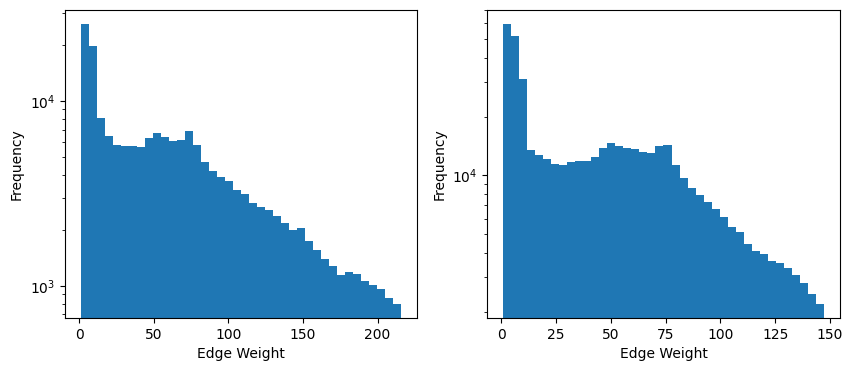

In [19]:
plt.figure(figsize=(10,4))

for ith, G in enumerate([G_bu, G_tu]):
    plt.subplot(1,2,ith+1)
    allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                         if d[2]["weight"] < quant_dist[G.name][-2]})
    allEdgesWeightsFiltered.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel("Edge Weight")

#### Betweeness centrality

Bipartite Undirect: 0.0007220813495247776
Tripartite Undirect: 1.3751972752978146e-05


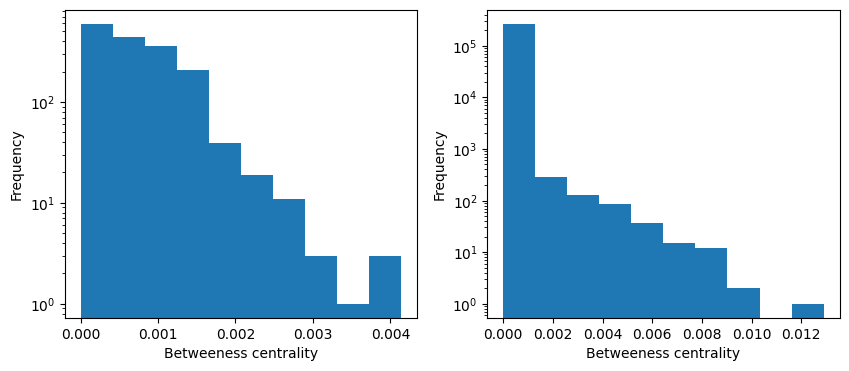

In [20]:
plt.figure(figsize=(10,4))

for ith, G in enumerate([G_bu, G_tu]):
    plt.subplot(1,2,ith+1)

    bC = nx.betweenness_centrality(G, k=200)
    bc_distr = pd.Series(bC)
    print(f"{G.name}: {bc_distr.mean()}")
    bc_distr.plot.hist()
    plt.yscale("log")
    plt.xlabel("Betweeness centrality")

#### Degree centrality

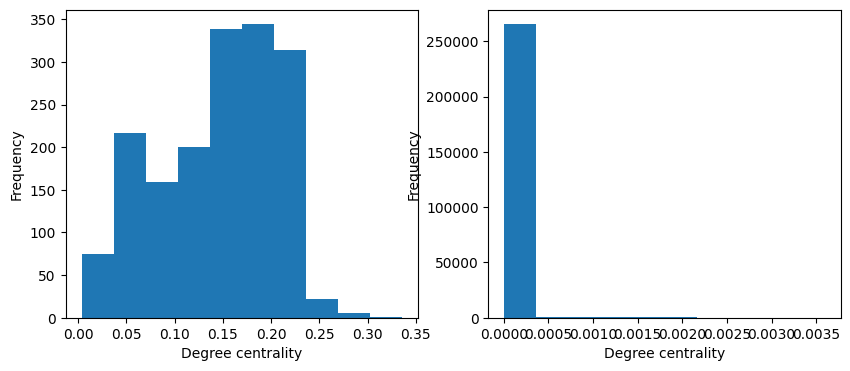

In [21]:
plt.figure(figsize=(10,4))

for ith, G in enumerate([G_bu, G_tu]):
    plt.subplot(1,2,ith+1)
    
    deg_C = nx.degree_centrality(G)
    degc_distr = pd.Series(deg_C) #.apply(np.log)
    degc_distr.plot.hist()

    plt.xlabel("Degree centrality")

#### Assortativity

In [22]:
for ith, G in enumerate([G_bu, G_tu]):
    assortativity = nx.degree_pearson_correlation_coefficient(G)
    print(f"{G.name}: {assortativity}")

Bipartite Undirect: -0.13774320410491867
Tripartite Undirect: -0.8079472914876619


### Community Detection

In [23]:
import community

#### Bipartite Graph

In [24]:
G=G_bu

In [25]:
parts = community.best_partition(G, random_state=42, weight='weight')

In [26]:
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False).head(15)

2     465
13    234
0     148
5     133
10    113
9      99
8      93
1      87
12     80
6      72
4      66
7      57
11     20
3       9
dtype: int64

Text(0.5, 0, 'Community size')

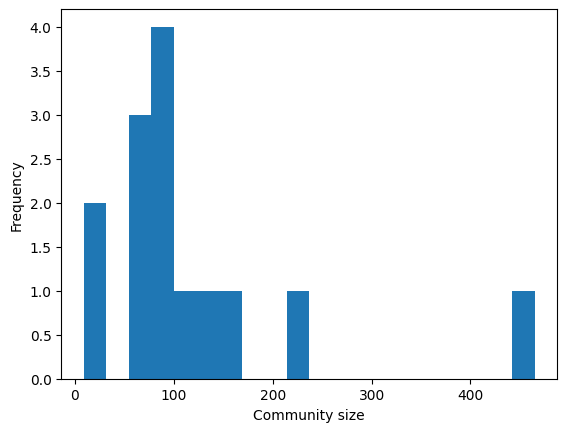

In [27]:
communities.value_counts().plot.hist(bins=20)
plt.xlabel("Community size")

In [28]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False).head(15)

4     20.289855
5     18.671454
11    18.181818
8     17.281879
6     15.591398
0     14.538462
7     10.769231
12    10.758377
1      9.883721
10     9.622642
9      7.707317
2      2.969694
13     1.297648
3      0.000000
dtype: float64

Text(0.5, 0, 'Fraud over genuine ratio')

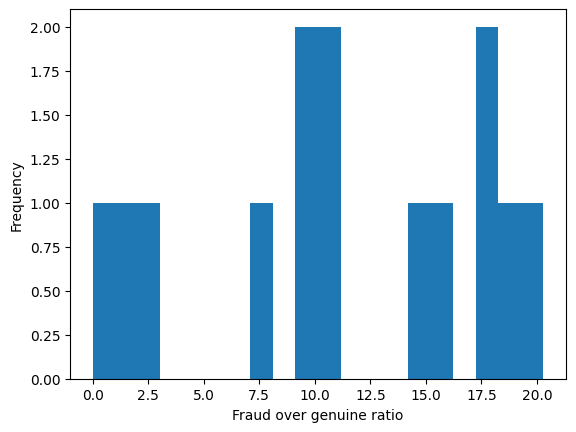

In [29]:
pd.Series(d).plot.hist(bins=20) 
plt.xlabel("Fraud over genuine ratio")

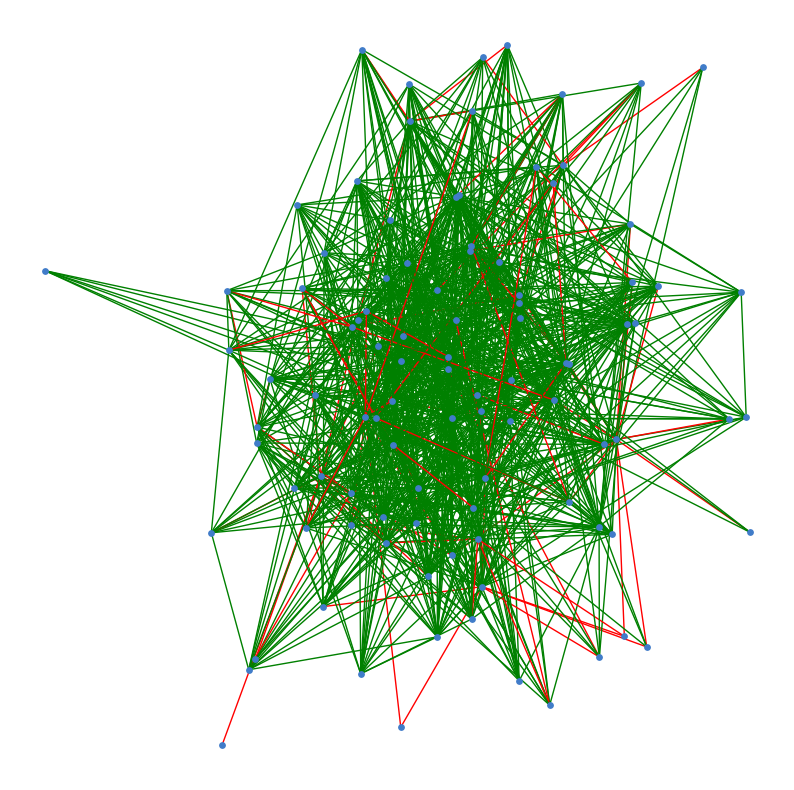

In [30]:
gId = 8
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

#### Tripartite Graph

In [31]:
G = G_tu

In [32]:
parts = community.best_partition(G, random_state=42, weight='weight')

In [33]:
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False).head(15)

11    4828
99    4493
26    4313
94    4115
8     4036
5     4011
82    3768
97    3740
2     3712
83    3699
64    3600
7     3598
53    3522
48    3457
73    3341
dtype: int64

Text(0.5, 0, 'Community size')

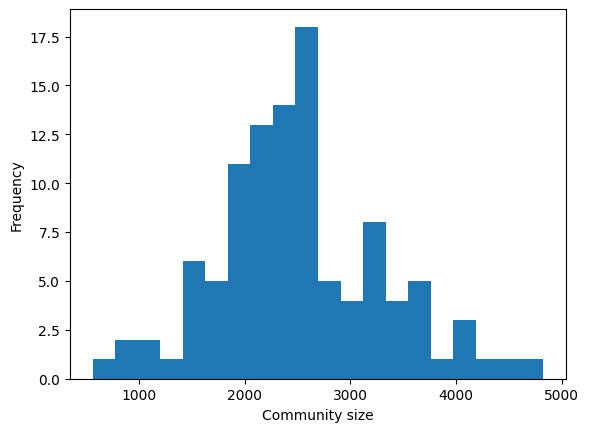

In [34]:
communities.value_counts().plot.hist(bins=20)
plt.xlabel("Community size")

In [35]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False).head(15)

6     6.857728
94    6.551151
8     5.966981
1     5.870918
89    5.760271
14    5.653863
76    5.628272
57    5.205479
80    5.182421
98    5.100182
30    5.078895
40    5.047319
34    5.023761
86    4.874715
96    4.678899
dtype: float64

Text(0.5, 0, 'Fraud over genuine ratio')

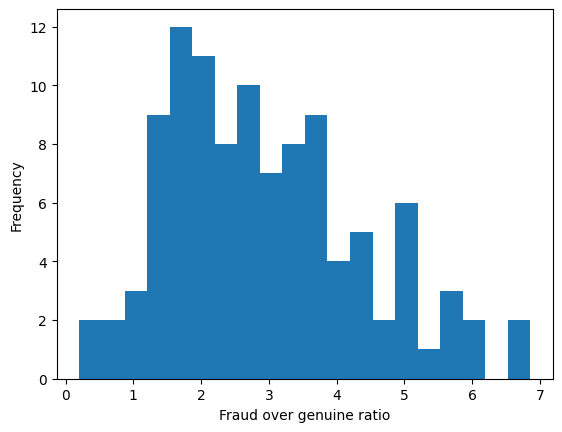

In [36]:
pd.Series(d).plot.hist(bins=20) 
plt.xlabel("Fraud over genuine ratio")

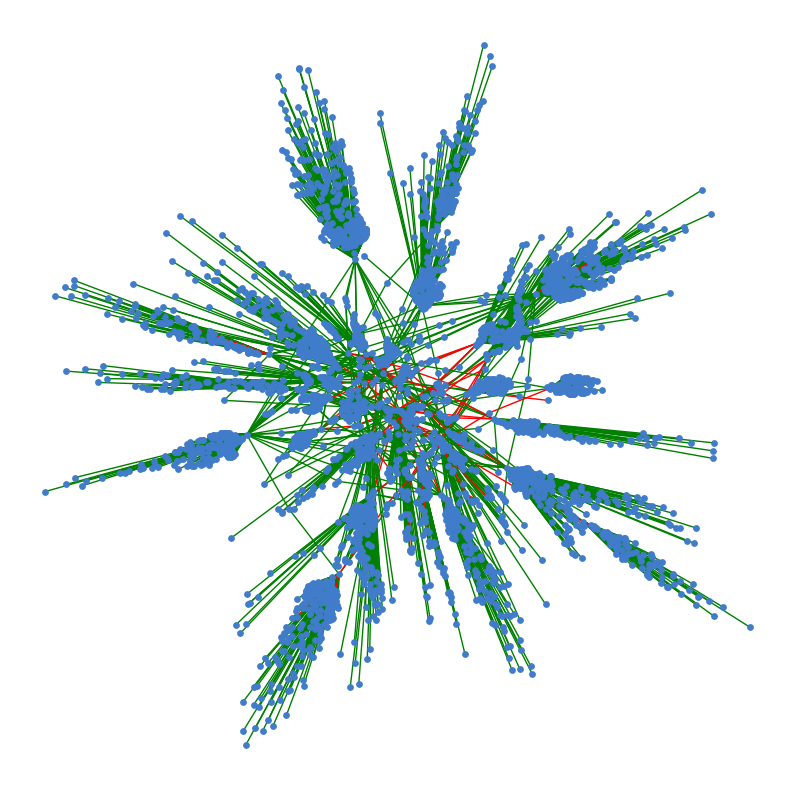

In [37]:
gId = 8
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

## Supervised Learning

In [38]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    7506
0    7506
Name: is_fraud, dtype: int64


In [39]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [40]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [41]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]


In [42]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.7599611273080661
Recall: 0.5308893414799728
F1-Score: 0.6250999200639488
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7164073550212164
Recall: 0.6877121520706042
F1-Score: 0.7017665396605473
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.6199316072300928
Recall: 0.8615071283095723
F1-Score: 0.7210227272727273
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.6205378973105135
Recall: 0.8615071283095723
F1-Score: 0.7214326321773735


## Unupervised Learning

In [43]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/it]


In [44]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.35357823566898267
Homogeneity: 0.34218086499728617
Completeness: 0.3658315862407637
V-Measure: 0.3536112067077341
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.06722811041159231
Homogeneity: 0.06631911824164934
Completeness: 0.06825845272397836
V-Measure: 0.06727481206136121
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.06433043718212811
Homogeneity: 0.06437090274809783
Completeness: 0.0643823427937208
V-Measure: 0.06437662226267107
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.05071791824826933
Homogeneity: 0.05017348061331937
Completeness: 0.051371296699734594
V-Measure: 0.05076532397326684
